In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_style("whitegrid")
import numpy as np
import pandas as pd
import json
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from scipy.cluster.hierarchy import dendrogram
import scipy
import traceback
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

In [2]:
dataset_name_dict = {'Mallat': 0,
 'UWaveGestureLibraryAll': 1,
 'NonInvasiveFetalECGThorax2': 2,
 'MixedShapesRegularTrain': 3,
 'MixedShapesSmallTrain': 4,
 'ECG5000': 5,
 'NonInvasiveFetalECGThorax1': 6,
#  'MoteStrain': 7,
 "StarLightCurves":7,
 'HandOutlines': 8,
 'UWaveGestureLibraryX': 9,
 'CBF': 10,
 'InsectWingbeatSound': 11,
 'UWaveGestureLibraryY': 12,
 'ShapesAll': 13,
 'SonyAIBORobotSurface2': 14,
 'FreezerSmallTrain': 15,
  'Crop':16,
 'ElectricDevices':17}

In [3]:
data_information = json.load(open("dataset_information.json"))
data_information = json.loads(data_information)

In [4]:
kmeans_times = pd.read_csv("./kmeans.csv").dropna(how="all")
kmeans_spectral_times = pd.read_csv("./kmeans_spectral.csv").dropna(how="all")
tmfg_matlab_times = pd.read_csv("./tmfg-matlab.csv").dropna(how="all")
pmfg_times = pd.read_csv("./pmfg.csv").dropna(how="all")
hac_times = pd.read_csv("./hac.csv").dropna(how="all")
tmfg_times = pd.read_csv("./tmfg.csv").dropna(how="all")

In [5]:
scores = pd.concat([kmeans_times, kmeans_spectral_times, tmfg_matlab_times, pmfg_times, hac_times, tmfg_times], 
                   ignore_index=True, axis=0)

In [6]:
scores["score"] = scores["score"].astype(float)
scores["info_score"] = scores["info_score"].astype(float)
scores = scores.drop(columns = ["Unnamed: 0"])
scores.loc[:,"ID"]=scores["ID"]+1 #ID starts with 1
scores.loc[scores["method"]=="kmeans","method"] = "k-means"
scores.loc[scores["method"]=="kmeans_spectral","method"] = "k-means-s"
scores.loc[:,"method"]=scores["method"].str.upper()

## plot quality

In [124]:
scores_subset = scores[scores["method"].isin(["COMP", "AVG","K-MEANS", "K-MEANS-S", "PMFG", "TMFG_1", "TMFG_10"])]
scores_subset = scores_subset[["dataset", "method", "ID", "score", "info_score"]].drop_duplicates()
scores_subset = scores_subset.groupby(["dataset", "method"]).max().reset_index().drop_duplicates()
# scores_max = scores[scores["method"].isin(["TMFG_2","TMFG_5", "TMFG_10", "TMFG_30", "TMFG_50"])].groupby(["dataset"]).max()
# scores_max = scores_max.drop(columns = ["workers", "time", "speedup"])
# scores_max["method"] = "TMFG-PREFIX"
# scores_max = scores_max.reset_index()
scores_concat = pd.concat([scores_subset])#, scores_max
# scores_concat.loc[scores_concat["method"]=="TMFG_1", "method"] = "TMFG-EXACT"
scores_concat["ID"] = scores_concat["ID"].astype(float).astype(int).astype(str)

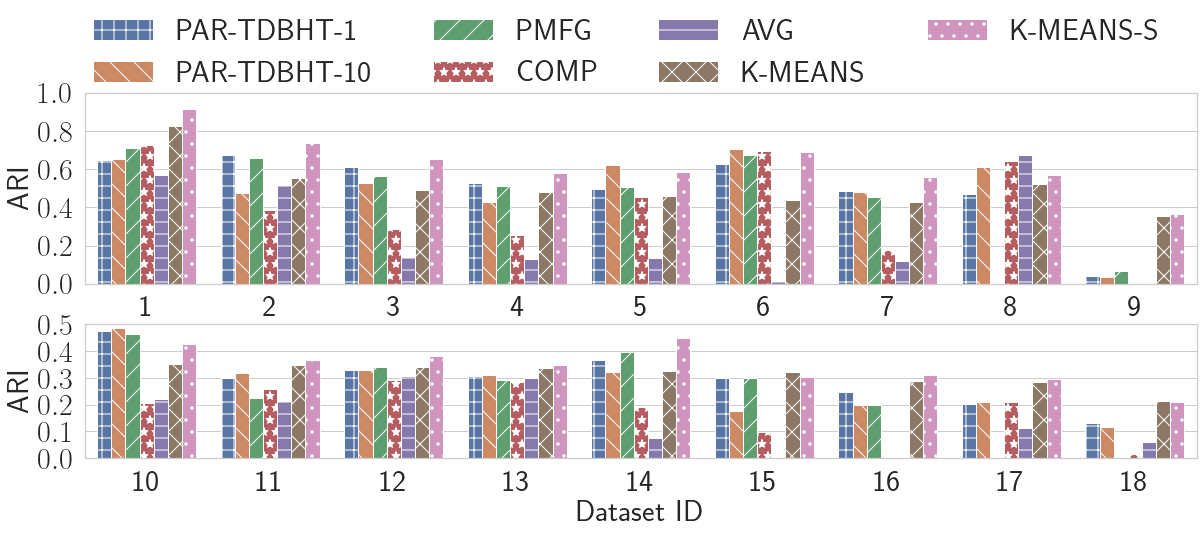

In [125]:
fig, axs = plt.subplots(2,1,figsize=(16,7), gridspec_kw={'height_ratios': [1, 0.7]})
bar = sns.barplot(x="ID",
           y="score",
           hue="method",
           data=scores_concat[scores_concat["ID"].isin([ '1', '2', '3', '4', '5', '6', '7','8','9'])],
           order = ['1', '2', '3', '4', '5', '6', '7','8','9'],
           hue_order=['TMFG_1', 'TMFG_10', 'PMFG', 'COMP', 'AVG', 'K-MEANS',
       'K-MEANS-S'],
           ax=axs[0])

bar = sns.barplot(x="ID",
           y="score",
           hue="method",
           data=scores_concat[~scores_concat["ID"].isin(['1', '2', '3', '4', '5', '6', '7','8','9'])],
            order = ["10", "11", '12', '13', '14', '15','16','17','18'],
            hue_order=['TMFG_1', 'TMFG_10', 'PMFG', 'COMP', 'AVG', 'K-MEANS',
       'K-MEANS-S'],
           ax=axs[1])

axs[0].legend().set_visible(False)
axs[1].legend().set_visible(False)
axs[0].set_xlabel("")
axs[1].set_xlabel("Dataset ID", fontsize = 30)
axs[0].set_ylabel("ARI", fontsize = 30)
axs[1].set_ylabel("ARI", fontsize = 30)

for myax in axs:
    for l in myax.yaxis.get_ticklabels():
        l.set_fontsize(30)
    for l in myax.xaxis.get_ticklabels():
        l.set_fontsize(30)

handles, labels = axs[0].get_legend_handles_labels()

for i in range(len(handles)):
    if(labels[i]=="TMFG_1"):
        labels[i] = "PAR-TDBHT-1"
    if(labels[i]=="TMFG_10"):
        labels[i] = "PAR-TDBHT-10"
    
# Define some hatches
hatches = ['+', '\\', '/',  '*', '-', 'x', '.', 'o', 'O', '|']

# Loop over the bars
for j in range(2):
    for i,thisbar in enumerate(axs[j].patches):
        thisbar.set_hatch(hatches[i //9])
    
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,0.5)


# plt.subplots_adjust(left=0.08,right=0.995, top=0.85,wspace=0.15, hspace = 0.15)
lgd = fig.legend(handles, labels, loc=9, ncol=4,bbox_to_anchor=(0.5, 1.05),frameon=False, fontsize = 30)#
plt.subplots_adjust(left=0.03,right=0.995, top=0.85,wspace=0.1, hspace = 0.25)
fig.savefig("./figures/clustering_quality_bar-new.pdf", bbox_inches='tight' )

In [126]:
scores_tmfg = scores[["dataset","ID","score","info_score","method", "prefix"]]
scores_tmfg = scores_tmfg[scores_tmfg["method"].isin(np.char.upper(["tmfg_1", "tmfg_2","tmfg_5", "tmfg_10", "tmfg_30", "tmfg_50", "tmfg_200"]))]
scores_tmfg.loc[scores_tmfg["method"]=="PMFG", "prefix"]="0"
scores_tmfg.loc[scores_tmfg["method"]=="TMFG_1", "prefix"]="1"
scores_tmfg.loc[scores_tmfg["method"]=="TMFG_2", "prefix"]="2"
scores_tmfg.loc[scores_tmfg["method"]=="TMFG_5", "prefix"]="5"
scores_tmfg.loc[scores_tmfg["method"]=="TMFG_10", "prefix"]="10"
scores_tmfg.loc[scores_tmfg["method"]=="TMFG_30", "prefix"]="30"
scores_tmfg.loc[scores_tmfg["method"]=="TMFG_50", "prefix"]="50"
scores_tmfg.loc[scores_tmfg["method"]=="TMFG_200", "prefix"]="200"
scores_tmfg.drop_duplicates(inplace=True)
scores_tmfg["ID"] = scores_tmfg["ID"].astype(float).astype(int).astype(str)

In [127]:
cmp = sns.color_palette("gist_yarg_r", 9)

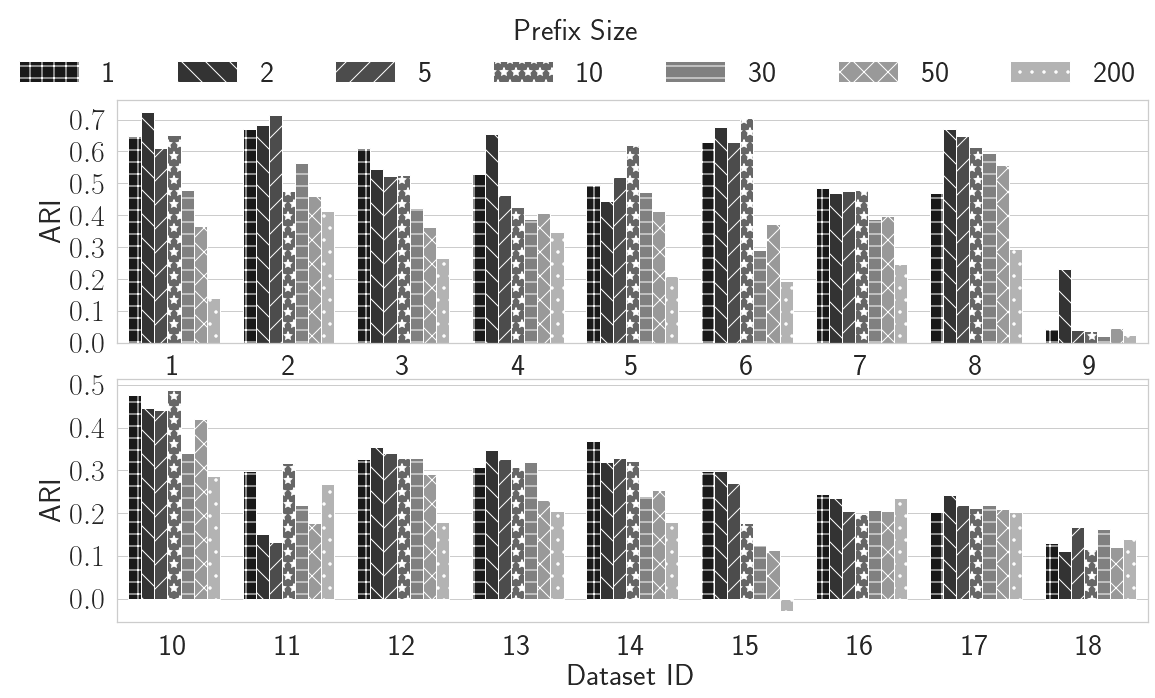

In [128]:
fig, axs = plt.subplots(2,1,figsize=(16,10))
sns.barplot(x="ID",
           y="score",
           hue="prefix",
           data=scores_tmfg[scores_tmfg["ID"].isin(['1', '2', '3', '4', '5', '6', '7','8','9'])],
           hue_order=["1","2","5","10","30","50", "200"],
            palette = cmp[:8],
           ax=axs[0])

sns.barplot(x="ID",
           y="score",
           hue="prefix",
           data=scores_tmfg[~scores_tmfg["ID"].isin([ '1', '2', '3', '4', '5', '6', '7','8','9'])],
            hue_order=["1","2","5","10","30","50", "200"],
            palette =  cmp[:8],
           ax=axs[1])

axs[0].legend().set_visible(False)
axs[1].legend().set_visible(False)
axs[0].set_xlabel("")
axs[1].set_xlabel("Dataset ID", fontsize = 30)
axs[0].set_ylabel("ARI", fontsize = 30)
axs[1].set_ylabel("ARI", fontsize = 30)

for myax in axs:
    for l in myax.yaxis.get_ticklabels():
        l.set_fontsize(30)
    for l in myax.xaxis.get_ticklabels():
        l.set_fontsize(30)
        
# Define some hatches
hatches = ['+', '\\', '/',  '*', '-', 'x', '.', 'o', 'O', '|']

# Loop over the bars
for j in range(2):
    for i,thisbar in enumerate(axs[j].patches):
        thisbar.set_hatch(hatches[i //9])
        
handles, labels = axs[0].get_legend_handles_labels()

for i in range(len(handles)):
    if(labels[i]=="0"):
        labels[i] = "PMFG"
#     labels[i] = int(float(labels[i]))
plt.subplots_adjust(left=0.1,right=0.995, top=0.85,wspace=0.15, hspace = 0.15)
fig.legend(handles, labels, loc=9, ncol=8,bbox_to_anchor=(0.5, 1), title="Prefix Size", frameon=False, fontsize = 30,title_fontsize=30)
plt.savefig("./figures/clustering_quality_prefix-new.pdf")

In [40]:
scores_edgesum = pd.concat([pmfg_times, tmfg_times], ignore_index=True, axis=0)
scores_edgesum = scores_edgesum[["dataset","ID","edge_sum","method", "prefix"]]
scores_edgesum.drop_duplicates(inplace=True)
scores_edgesum.loc[:,"method"]=scores_edgesum["method"].str.upper()
scores_edgesum.loc[:,"ID"]=scores_edgesum["ID"]+1 #ID starts with 1


# scores_tmfg = scores_tmfg[scores_tmfg["method"].isin(np.char.upper(["tmfg_1", "tmfg_2","tmfg_5", "tmfg_10", "tmfg_30", "tmfg_50", "tmfg_200"]))]
scores_edgesum.loc[scores_edgesum["method"]=="PMFG", "prefix"]=0
scores_edgesum["prefix"] = scores_edgesum["prefix"].astype(int).astype(str)
scores_edgesum["ID"] = scores_edgesum["ID"].astype(str)

df_tmfg_1 = scores_edgesum[scores_edgesum["method"]=="TMFG_1"]
scores_edgesum["edge_sum_ratio"] = scores_edgesum.apply(
    lambda x: x["edge_sum"] / float(df_tmfg_1[df_tmfg_1["ID"]==x["ID"]]["edge_sum"]), 
                                                        axis=1, result_type='expand')

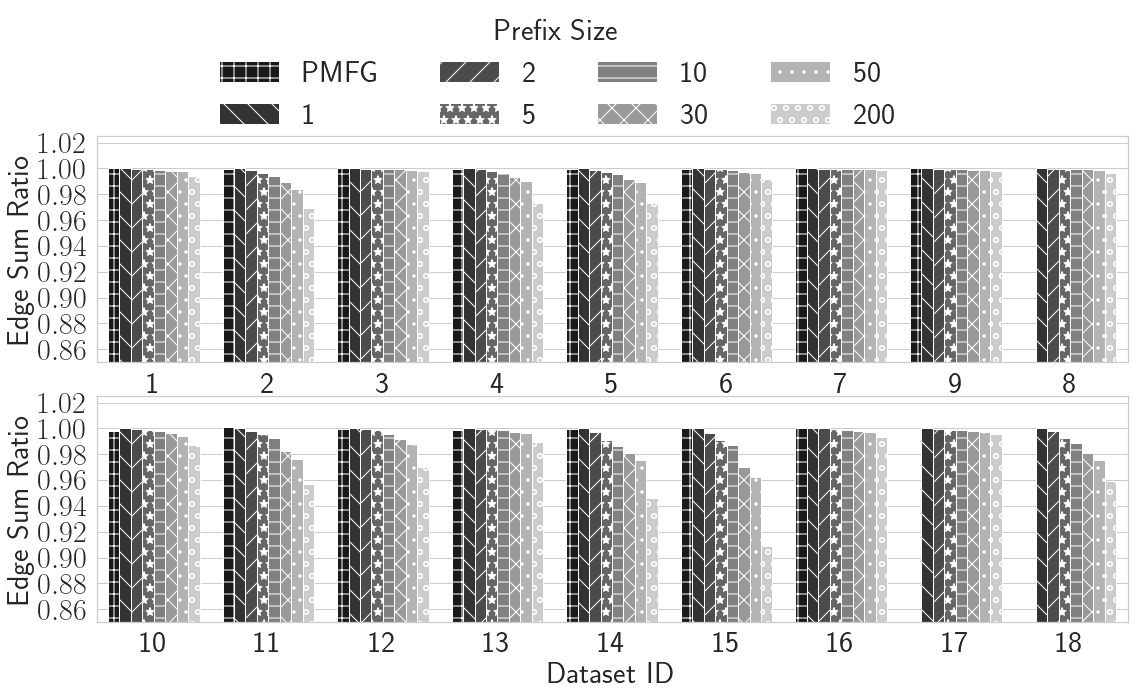

In [44]:
cmp = sns.color_palette("gist_yarg_r", 9)
fig, axs = plt.subplots(2,1,figsize=(16,10))
sns.barplot(x="ID",
           y="edge_sum_ratio",
           hue="prefix",
           data=scores_edgesum[scores_edgesum["ID"].isin(['1', '2', '3', '4', '5', '6', '7','8','9'])],
           hue_order=["0","1","2","5","10","30","50", "200"],
            palette = cmp[:9],
           ax=axs[0])

sns.barplot(x="ID",
           y="edge_sum_ratio",
           hue="prefix",
           data=scores_edgesum[~scores_edgesum["ID"].isin([ '1', '2', '3', '4', '5', '6', '7','8','9'])],
            hue_order=["0", "1","2","5","10","30","50", "200"],
            palette =  cmp[:9],
           ax=axs[1])

axs[0].legend().set_visible(False)
axs[1].legend().set_visible(False)
axs[0].set_xlabel("")
axs[1].set_xlabel("Dataset ID", fontsize = 30)
axs[0].set_ylabel("Edge Sum Ratio", fontsize = 30)
axs[1].set_ylabel("Edge Sum Ratio", fontsize = 30)




for myax in axs:
    myax.set_ylim(0.85, 1.025)
    for l in myax.yaxis.get_ticklabels():
        l.set_fontsize(30)
    for l in myax.xaxis.get_ticklabels():
        l.set_fontsize(30)
        
# Define some hatches
hatches = ['+', '\\', '/',  '*', '-', 'x', '.', 'o', 'O', '|']

# Loop over the bars
for j in range(2):
    for i,thisbar in enumerate(axs[j].patches):
        thisbar.set_hatch(hatches[i //9])
        
handles, labels = axs[0].get_legend_handles_labels()

for i in range(len(handles)):
    if(labels[i]=="0"):
        labels[i] = "PMFG"
#     labels[i] = int(float(labels[i]))

plt.subplots_adjust(left=0.1,right=0.995, top=0.8,wspace=0.15, hspace = 0.15)
fig.legend(handles, labels, loc=9, ncol=4,bbox_to_anchor=(0.5, 1), title="Prefix Size", frameon=False, fontsize = 30,title_fontsize=30)
plt.savefig("./figures/clustering_quality_prefix_edgesum.pdf")

## plot times

In [129]:
palette = {"TMFG-EXACT":"blue", 
          "TMFG-PREFIX":"green", 
           "TMFG_1":"blue", 
          "TMFG_10":"green", 
           "TMFG-1":"green", 
           "TMFG-2":"green", 
           "TMFG-5":"green", 
           "TMFG-10":"green", 
           "TMFG-30":"green", 
           "TMFG-50":"green", 
           "TMFG-M":"brown", 
          "PMFG":"orange",
           "COMP":"purple",
            "AVG":"pink",
           "K-MEANS":"black",
           "K-MEANS-S":"black"
          }

scores_subset = scores[scores["method"].isin(np.char.upper(["comp", "avg","k-means", "pmfg", "tmfg_1","tmfg_10", "TMFG-M"]))]
scores_subset = scores_subset[["dataset","workers", "method", "ID", "time"]].drop_duplicates()
scores_concat = pd.concat([scores_subset]) #, scores_max
scores_concat.loc[scores_concat["method"].isin(["COMP"]), "ID"] = scores_concat.loc[scores_concat["method"].isin(["COMP"]), "ID"]-0.15
scores_concat.loc[scores_concat["method"].isin(["AVG"]), "ID"] = scores_concat.loc[scores_concat["method"].isin(["AVG"]), "ID"]+0.15
scores_concat.loc[scores_concat["method"].isin(["TMFG_1"]), "ID"] = scores_concat.loc[scores_concat["method"].isin(["TMFG_1"]), "ID"]-0.15
scores_concat.loc[scores_concat["method"].isin(["TMFG_10"]), "ID"] = scores_concat.loc[scores_concat["method"].isin(["TMFG_10"]), "ID"]+0.15

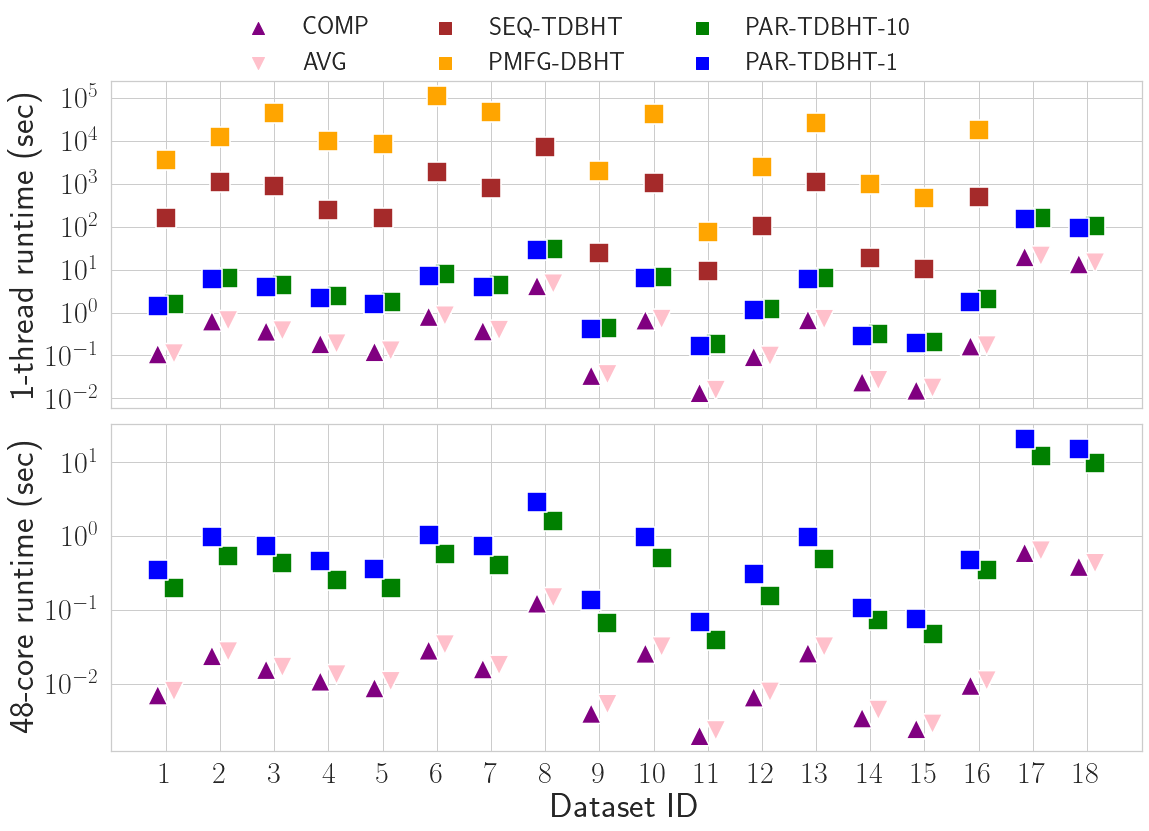

In [130]:
def plot_time(ax, w, ylabel, scores_concat, legend = True):
    
    scores_kmeans = scores_concat[(scores_concat["workers"]==12) & (scores_concat["method"]=="K-MEANS")]
    scores_concat = scores_concat[scores_concat["workers"]==w]
    
    sns.scatterplot(x="ID", y="time", hue = "method", style="method",s=400,
                    data=scores_concat[scores_concat["method"].isin(
                        ["COMP", "AVG"]
                    )],
                   palette=palette,
                     markers=['^', 'v'],
                    ax = ax
                   )
    if w==1:
        sns.scatterplot(x="ID", y="time", hue = "method", style="method",s=400,
                    data=scores_concat[scores_concat["method"].isin(
                        ["TMFG_1", "TMFG_10", "PMFG", "TMFG-M"]
                    )],
                         markers=['s','s','s', 's'],
                         palette=palette,
                   ax = ax)
#         sns.scatterplot(x="ID", y="time", hue = "method", style="method",s=400,
#                     data=scores_concat[scores_concat["method"].isin(
#                         ["K-MEANS"]
#                     )], ax = ax,
#                    palette=palette)
        
    else:
         sns.scatterplot(x="ID", y="time", hue = "method", style="method",s=400,
                    data=scores_concat[scores_concat["method"].isin(
                        ["TMFG_1", "TMFG_10"]
                    )],
                         markers=['s','s'],
                         palette=palette,
                   ax = ax)
#          sns.scatterplot(x="ID", y="time", hue = "method", style="method",s=400,
#                     data=scores_kmeans, ax = ax,
#                    palette=palette)
        
    ax.set_xlabel("Dataset ID", fontsize = 35)
    ax.set_ylabel("%s runtime (sec)" % ylabel, fontsize = 35)
    ax.set_xticks(list(np.arange(1,len(dataset_name_dict)+1,1)));
    ax.set_yscale('log')
    ax.legend().set_visible(False)
    
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(30)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(30)

fig, axs = plt.subplots(2,1,figsize=(16,12), sharex = True)
# sns.set(font_scale=2) 
sns.set_style("whitegrid")

plot_time(axs[0],1,"1-thread",scores_concat)
plot_time(axs[1], 96, "48-core", scores_concat,False)

handles, labels = axs[0].get_legend_handles_labels()

for i in range(len(handles)):
    if(labels[i]=="TMFG_1"):
        labels[i] = "PAR-TDBHT-1"
    if(labels[i]=="TMFG_10"):
        labels[i] = "PAR-TDBHT-10"
    if(labels[i]=="TMFG-M"):
        labels[i] = "SEQ-TDBHT"
    if(labels[i]=="PMFG"):
        labels[i] = "PMFG-DBHT"
    
fig.legend(handles, labels, loc=9, ncol=3,bbox_to_anchor=(0.5, 1), frameon=False, markerscale=2, fontsize = 25)#
plt.subplots_adjust(left=0.1,right=0.995, top=0.9,wspace=0.1, hspace = 0.05)
plt.savefig("./figures/time-new.pdf" )

## intro fig

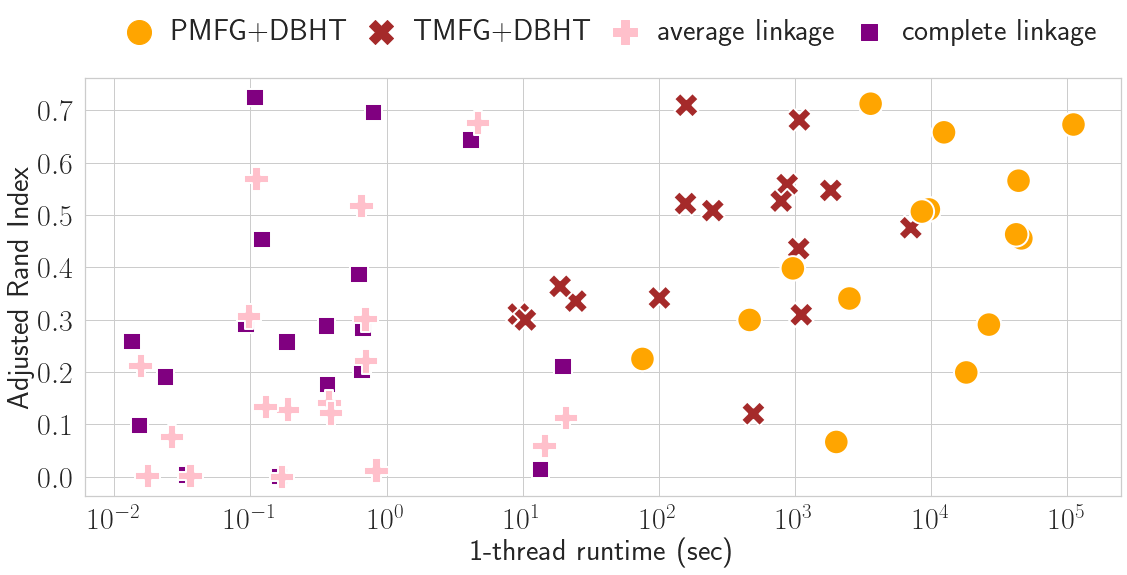

In [131]:
scores_pmfg = scores[scores["method"]=="PMFG"].drop(columns=["edge_sum","speedup"])
scores_par =  scores[scores["workers"]==1].drop(columns=["edge_sum","speedup"])
scores_par = scores_par[scores_par["method"]!="TMFG_200"]
scores_concat = pd.concat([scores_pmfg, scores_par])#
scores_concat.loc[scores_concat["method"]=="TMFG_1", "method"]="TMFG-1"
scores_concat.loc[scores_concat["method"]=="TMFG_2", "method"]="TMFG-2"
scores_concat.loc[scores_concat["method"]=="TMFG_5", "method"]="TMFG-5"
scores_concat.loc[scores_concat["method"]=="TMFG_10", "method"]="TMFG-10"
scores_concat.loc[scores_concat["method"]=="TMFG_30", "method"]="TMFG-30"
scores_concat.loc[scores_concat["method"]=="TMFG_50", "method"]="TMFG-50"

fig, axs = plt.subplots(1,1 ,figsize=(16,8))
sns.set_style("whitegrid")

sns.scatterplot(
    x = "time",
    y = "score",
    hue="method",
    style="method",
    palette=palette,
    data = scores_concat[~scores_concat["method"].isin(["TMFG-2",
                                                        "TMFG-5",
                                                        "TMFG-10",
                                                        "TMFG-30",
                                                        "TMFG-50",
                                                        "TMFG-1",
                                                        "K-MEANS","K-MEANS-S"])],
    s = 600,
    ax = axs

)
axs.legend().set_visible(False)
axs.set_ylabel("Adjusted Rand Index", fontsize = 30)
axs.set_xlabel("1-thread runtime (sec)", fontsize = 30)

for myax in [axs]:
    for l in myax.yaxis.get_ticklabels():
        l.set_fontsize(30)
    for l in myax.xaxis.get_ticklabels():
        l.set_fontsize(30)
        
handles, labels = axs.get_legend_handles_labels()
for i in range(len(labels)):
    if(labels[i] == "TMFG-1"):
        labels[i] = "OURS" 
    if(labels[i] == "TMFG-M"):
        labels[i] = "TMFG+DBHT" 
    if(labels[i] == "PMFG"):
        labels[i] = "PMFG+DBHT" 
    if(labels[i] == "AVG"):
        labels[i] = "average linkage" 
    if(labels[i] == "COMP"):
        labels[i] = "complete linkage" 
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))


plt.xscale("log")
plt.subplots_adjust(left=0.1,right=0.999, top=0.85,wspace=0.1, hspace = 0.1)
# plt.tight_layout()
fig.legend(handles, labels, loc=9, ncol=4,bbox_to_anchor=(0.55, 1), markerscale=4, columnspacing=0.1, handletextpad = 0.1, frameon=False, fontsize = 30)#
plt.savefig("./figures/timevscore-intro-new.pdf" )

## compute numbers

In [30]:
# PMFG. TMFG speeds

In [133]:
scores_PMFG = scores[scores["method"]=="PMFG"].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_1") & (scores["workers"]==1) & (~scores["ID"].isin([8, 17,18]))].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))

455.02--15588.92


In [134]:
scores_PMFG = scores[scores["method"]=="PMFG"].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_10") & (scores["workers"]==1) & (~scores["ID"].isin([8, 17,18]))].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))

415.95--14407.92


In [135]:
scores_PMFG = scores[scores["method"]=="TMFG-M"].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_1") & (scores["workers"]==1) & (~scores["ID"].isin([17,18]))].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))

scores_PMFG = scores[scores["method"]=="TMFG-M"].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_10") & (scores["workers"]==1) & (~scores["ID"].isin([17,18]))].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))

53.81--274.89
50.45--239.15


In [136]:
scores_PMFG = scores[scores["method"]=="TMFG-M"].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_1") & (scores["workers"]==96) & (~scores["ID"].isin([17,18]))].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))

scores_PMFG = scores[scores["method"]=="TMFG-M"].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_50") & (scores["workers"]==96) & (~scores["ID"].isin([17,18]))].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))

135.97--2483.06
447.53--7987.02


In [137]:
scores_PMFG = scores[scores["method"]=="TMFG-M"].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_5") & (scores["workers"]==96) & (~scores["ID"].isin([17,18]))].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))

151.34--2949.37


In [138]:
## kmeans, TMFG

In [139]:
scores_PMFG = scores[(scores["method"]=="K-MEANS") & (scores["workers"]==12)].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_1") & (scores["workers"]==96)].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))
print(np.average(speedups))

0.05--5.11
1.008525087788948


In [140]:
scores_PMFG = scores[(scores["method"]=="K-MEANS") & (scores["workers"]==12)].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_10") & (scores["workers"]==96)].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))
print(np.average(speedups))

0.08--7.36
1.7357594293444742


In [141]:
scores_PMFG = scores[(scores["method"]=="K-MEANS-S") & (scores["workers"]==12)].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_1") & (scores["workers"]==96)].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))
print(np.average(speedups))

1.05--69.48
10.224816735643982


In [142]:
scores_PMFG = scores[(scores["method"]=="K-MEANS-S") & (scores["workers"]==12)].sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"]=="TMFG_10") & (scores["workers"]==96)].sort_values(by=["ID"])
speedups = scores_PMFG["time"].to_numpy() / scores_TMFG_1["time"].to_numpy()
print("%.2f--%.2f" % (np.min(speedups), np.max(speedups) ))
print(np.average(speedups))

1.76--125.55
17.464275983380393


In [143]:
np.max(tmfg_times["speedup"])

43.2332240344368

In [159]:
np.max(tmfg_times[tmfg_times["workers"]==96]["time"])

26.064987897872925

## edge_sum

In [157]:
min_p = 1
max_p = 0
scores_PMFG = scores[(scores["method"]=="PMFG") ].sort_values(by=["ID"])
for prefix in [1,2,5,10,30,50]:
    scores_TMFG_1 = scores[(scores["method"]=="TMFG_%s"%prefix) & (scores["workers"]==96) & (~scores["ID"].isin([8, 17,18]))].sort_values(by=["ID"])
    speedups = scores_TMFG_1["edge_sum"].to_numpy() /scores_PMFG["edge_sum"].to_numpy() 
    min_p = min(min_p, np.min(speedups))
    max_p = max(max_p, np.max(speedups))
    print(np.max(speedups))

1.00189217377795
1.0015884884161534
1.0006944145155758
1.000092690697175
0.9995709965876596
0.9994194510356565


In [158]:
print("%.4f -- %.4f" % (min_p , max_p ))

0.9619 -- 1.0019


## HAC

In [160]:
scores_PMFG = scores[(scores["method"].isin(["COMP","AVG"]))].groupby(["dataset"]).min().sort_values(by=["ID"])
scores_TMFG_1 = scores[(scores["method"].isin(["TMFG_1","TMFG_2","TMFG_5","TMFG_10","TMFG_30","TMFG_50", "TMFG_200"]))].groupby(["dataset"]).max().sort_values(by=["ID"])

In [161]:
scores_TMFG_1

,workers,time,method,speedup,ID,score,info_score,edge_sum,n,prefix
dataset,,,,,,,,,,
Mallat,96,1.720571,TMFG_50,25.081587,1,0.724994,0.857892,14288.355266,2400,200.0
UWaveGestureLibraryAll,96,7.128919,TMFG_50,37.895320,2,0.715869,0.788032,23060.437816,4478,200.0
NonInvasiveFetalECGThorax2,96,4.779907,TMFG_50,33.225648,3,0.610122,0.819714,22481.810886,3765,200.0
MixedShapesRegularTrain,96,2.738152,TMFG_50,30.364991,4,0.654873,0.705061,16442.267089,2925,200.0
MixedShapesSmallTrain,96,1.968595,TMFG_50,26.912138,5,0.618890,0.668426,14162.234940,2525,200.0
ECG5000,96,8.735908,TMFG_50,38.862820,6,0.703634,0.591079,29200.108573,5000,200.0
NonInvasiveFetalECGThorax1,96,4.814641,TMFG_50,34.560367,7,0.485229,0.751760,22463.189879,3765,200.0
StarLightCurves,96,35.068022,TMFG_50,43.233224,8,0.669895,0.751489,54680.998200,9236,200.0
HandOutlines,96,0.502646,TMFG_50,15.594457,9,0.231434,0.231273,8137.694634,1370,200.0


In [162]:
speedups = scores_TMFG_1["score"].to_numpy() -scores_PMFG["score"].to_numpy() 
print("%.2f -- %.2f" % (np.min(speedups), np.max(speedups) ))

0.03 -- 0.69


#### TMFG and TMFG-M

In [146]:
tmfg_steps = pd.read_csv("tmfg_allsteps.csv").dropna(how="all")
tmfg_matlab_steps = pd.read_csv("tmfg-matlab_allsteps.csv").dropna(how="all")

In [147]:
scores_steps = pd.concat([tmfg_steps, tmfg_matlab_steps],ignore_index=True,  axis=0)

In [148]:
scores_steps = scores_steps.drop(columns = ["Unnamed: 0"])
scores_steps.loc[:,"ID"]=scores_steps["ID"]+1 #ID starts with 1
scores_steps.loc[scores_steps["method"]=="kmeans","method"] = "k-means"
scores_steps.loc[scores_steps["method"]=="kmeans_spectral","method"] = "k-means-s"
scores_steps.loc[:,"method"]=scores_steps["method"].str.upper()
scores_steps["dbht"] = scores_steps['apsp']+ scores_steps['bubble_tree'] + scores_steps['hierarchy']

In [149]:
def get_step_speedup(step, workers):
    times_m = scores_steps[scores_steps["method"]=="TMFG-M"][["dataset","ID",step, "method"]].sort_values(by=["ID"])
    min_p = 1000000
    max_p = 0
    for prefix in [1,2,5,10,30,50,200]:
        times_c = scores_steps[(scores_steps["method"]=="TMFG_%s"%prefix)&(scores_steps["workers"]==workers) & (~scores_steps["ID"].isin([17,18]))][["dataset","ID",step,"workers", "method"]].groupby(["dataset"]).min().sort_values(by=["ID"])
        speedups = times_m[step].to_numpy() / times_c[step].to_numpy()
        min_p = min(min_p, np.min(speedups))
        max_p = max(max_p, np.max(speedups))
    print("%.2f--%.2f" % (min_p , max_p ))

In [150]:
get_step_speedup("tmfg", 96)

16.40--10114.65


In [151]:
get_step_speedup("dbht", 96)

1309.49--14431.43


In [152]:
get_step_speedup("tmfg", 1)
get_step_speedup("dbht", 1)

12.27--319.15
63.66--432.31


## quality

In [133]:
scores_PMFG = scores[(scores["method"]=="K-MEANS") & (scores["workers"]==12)].sort_values(by=["ID"]).set_index("ID")
scores_TMFG_1 = scores[(scores["method"]=="TMFG_1") & (scores["workers"]==96)].sort_values(by=["ID"]).set_index("ID")
scores_TMFG_1["score"] > scores_PMFG["score"]

ID
1.0     False
2.0      True
3.0      True
4.0      True
5.0      True
6.0      True
7.0      True
8.0      True
9.0     False
10.0     True
11.0    False
12.0     True
13.0    False
14.0     True
15.0    False
16.0    False
Name: score, dtype: bool

In [135]:
scores_TMFG_1 = scores[(scores["method"]=="TMFG_10") & (scores["workers"]==96)].sort_values(by=["ID"]).set_index("ID")
scores_TMFG_1["score"] - scores_PMFG["score"]

ID
1.0    -0.116466
2.0    -0.009705
3.0    -0.031187
4.0     0.082607
5.0     0.052981
6.0     0.064480
7.0     0.011707
8.0    -0.122251
9.0    -0.283986
10.0    0.091192
11.0   -0.130956
12.0    0.024501
13.0   -0.055890
14.0   -0.000334
15.0   -0.091735
16.0   -0.014779
Name: score, dtype: float64

In [138]:
scores[(scores["method"]=="K-MEANS") & (scores["workers"]==12)]

,dataset,workers,time,method,speedup,ID,score,info_score,edge_sum
231,Mallat,12.0,0.296897,K-MEANS,2.098465,1.0,0.823736,0.916587,NaN
238,UWaveGestureLibraryAll,12.0,0.739039,K-MEANS,2.779201,2.0,0.554784,0.662047,NaN
245,NonInvasiveFetalECGThorax2,12.0,1.445504,K-MEANS,2.259602,3.0,0.491896,0.761183,NaN
252,MixedShapesRegularTrain,12.0,0.391145,K-MEANS,3.060286,4.0,0.477544,0.515417,NaN
259,MixedShapesSmallTrain,12.0,0.312384,K-MEANS,2.745996,5.0,0.460404,0.499045,NaN
266,ECG5000,12.0,0.243510,K-MEANS,1.795944,6.0,0.439386,0.484350,NaN
273,NonInvasiveFetalECGThorax1,12.0,1.479919,K-MEANS,2.237429,7.0,0.429523,0.702792,NaN
280,MoteStrain,12.0,0.042917,K-MEANS,1.191837,8.0,0.385214,0.296936,NaN
287,HandOutlines,12.0,0.307401,K-MEANS,2.688670,9.0,0.354562,0.252710,NaN
294,UWaveGestureLibraryX,12.0,0.384077,K-MEANS,2.321929,10.0,0.350594,0.438367,NaN


In [139]:
scores[(scores["method"]=="K-MEANS-S") & (scores["workers"]==12)]

,dataset,workers,time,method,speedup,ID,score,info_score,edge_sum
345,Mallat,12.0,0.839595,K-MEANS-S,0.854518,1.0,0.917068,0.938184,NaN
352,UWaveGestureLibraryAll,12.0,1.139302,K-MEANS-S,1.120191,2.0,0.738593,0.826003,NaN
359,NonInvasiveFetalECGThorax2,12.0,0.759593,K-MEANS-S,1.188003,3.0,0.654221,0.859586,NaN
366,MixedShapesRegularTrain,12.0,0.900290,K-MEANS-S,0.940559,4.0,0.579969,0.677984,NaN
373,MixedShapesSmallTrain,12.0,0.545687,K-MEANS-S,0.894755,5.0,0.584067,0.676838,NaN
380,ECG5000,12.0,1.784759,K-MEANS-S,0.840422,6.0,0.688142,0.618755,NaN
387,NonInvasiveFetalECGThorax1,12.0,0.968803,K-MEANS-S,1.088559,7.0,0.559868,0.798106,NaN
394,MoteStrain,12.0,0.373087,K-MEANS-S,0.594912,8.0,0.753097,0.650570,NaN
401,HandOutlines,12.0,0.885969,K-MEANS-S,0.845338,9.0,0.363051,0.256892,NaN
408,UWaveGestureLibraryX,12.0,2.940390,K-MEANS-S,0.986509,10.0,0.428103,0.509104,NaN
